In [631]:
import pandas as pd
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import warnings
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [632]:
#створення dataset
df = pd.read_csv('airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [633]:
#встановлення колонки datetime
df['Month'] = pd.to_datetime(df['Month']) 
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [634]:
s = pd.Series(index=df['Month'],
             data = df['Passengers'].values)
s

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Length: 144, dtype: int64

In [635]:
#розподілення на тренд, сезонність, залишок
result = seasonal_decompose(s, model='additive')

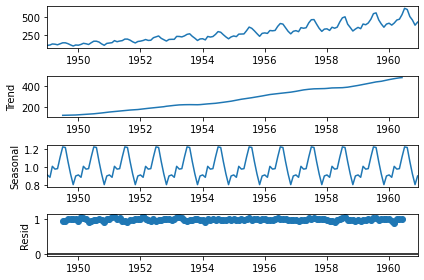

In [636]:
decompose_result = seasonal_decompose(s,model='multiplicative')
decompose_result.plot();

Прогноз на 1 місяць (зсув на 1 місяць)

In [637]:
#зсув на 1 міс, перевага має кращі метрики
df['yhat_simple'] = df['Passengers'].shift()
df

,Month,Passengers,yhat_simple
0,1949-01-01,112,NaN
1,1949-02-01,118,112.0
2,1949-03-01,132,118.0
3,1949-04-01,129,132.0
4,1949-05-01,121,129.0
...,...,...,...
139,1960-08-01,606,622.0
140,1960-09-01,508,606.0
141,1960-10-01,461,508.0
142,1960-11-01,390,461.0


In [638]:
px.line(df, x = 'Month', y = ['Passengers','yhat_simple'])

In [639]:
df_fill=df.fillna(method="bfill") #заповнимо NaN таким ж значенням як було, 0 заповнювати не зовсім коректно

In [640]:
df_fill 

,Month,Passengers,yhat_simple
0,1949-01-01,112,112.0
1,1949-02-01,118,112.0
2,1949-03-01,132,118.0
3,1949-04-01,129,132.0
4,1949-05-01,121,129.0
...,...,...,...
139,1960-08-01,606,622.0
140,1960-09-01,508,606.0
141,1960-10-01,461,508.0
142,1960-11-01,390,461.0


In [641]:
#метрики
X_test=df_fill[['Month','Passengers']]
X_pred=df_fill[['Month','yhat_simple']]

In [642]:
X_pred 

,Month,yhat_simple
0,1949-01-01,112.0
1,1949-02-01,112.0
2,1949-03-01,118.0
3,1949-04-01,132.0
4,1949-05-01,129.0
...,...,...
139,1960-08-01,622.0
140,1960-09-01,606.0
141,1960-10-01,508.0
142,1960-11-01,461.0


In [643]:
s_x_test = pd.Series(index=df_fill['Month'],
             data = df_fill['Passengers'].values)
s_x_test

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Length: 144, dtype: int64

In [644]:
s_x_pred = pd.Series(index=df_fill['Month'],
             data = df_fill['yhat_simple'].values)
s_x_pred

Month
1949-01-01    112.0
1949-02-01    112.0
1949-03-01    118.0
1949-04-01    132.0
1949-05-01    129.0
              ...  
1960-08-01    622.0
1960-09-01    606.0
1960-10-01    508.0
1960-11-01    461.0
1960-12-01    390.0
Length: 144, dtype: float64

In [558]:
print('r2_score',r2_score(s_x_test, s_x_pred))
print('MAE',mean_absolute_error(s_x_test, s_x_pred))
#маємо досить високе значення r2_score

r2_score 0.9210395951747054
MAE 25.680555555555557


SimpleExpSmoothing (Simple Exponential Smoothing (SES) for data without trend or seasonality)

In [566]:
train, test = s[0:-12], s[-12:]

In [567]:
#smoothing_level [0;1]
ses_0 = SimpleExpSmoothing(train) 
ses_fitted_0 = ses.fit(smoothing_level=0) #the forecasts are equal to the average of the historical data
ses_1 = SimpleExpSmoothing(train) 
ses_fitted_1 = ses.fit(smoothing_level=0.8)
ses_2 = SimpleExpSmoothing(train) 
ses_fitted_2 = ses.fit(smoothing_level=1) #the forecasts will be equal to the value of the last observation

In [568]:
preds = ses_fitted_0.forecast(len(test))
preds_2 = ses_fitted_1.forecast(len(test))
preds_3 = ses_fitted_2.forecast(len(test))

In [569]:
preds

1960-01-01    262.492424
1960-02-01    262.492424
1960-03-01    262.492424
1960-04-01    262.492424
1960-05-01    262.492424
1960-06-01    262.492424
1960-07-01    262.492424
1960-08-01    262.492424
1960-09-01    262.492424
1960-10-01    262.492424
1960-11-01    262.492424
1960-12-01    262.492424
Freq: MS, dtype: float64

In [570]:
preds = ses_fitted_0.forecast(len(test))
preds_2 = ses_fitted_1.forecast(len(test))
preds_3 = ses_fitted_2.forecast(len(test))

In [571]:
iplot(Figure([Scatter(x = train.index,
                     y = train.values,
                     name = 'Train data'),
             Scatter(x = test.index,
                     y = test.values,
                     name = 'Test data'),
             Scatter(x = preds.index,
                    y = preds.values,
                    name = 'Prediction'),
             Scatter(x = preds_2.index,
                    y = preds_2.values,
                    name = 'Prediction_2'),
             Scatter(x = preds_3.index,
                    y = preds_3.values,
                    name = 'Prediction_3')]))

In [572]:
print('preds',r2_score(test.values, preds))
print('preds2',r2_score(test.values, preds_2))
print('preds3',r2_score(test.values, preds_3))
#всі погані

preds -8.242063511469008
preds2 -1.0807462005136754
preds3 -0.9142918749780613


метод ExponentialSmoothing

In [565]:
train, test = s[0:-12], s[-12:]

In [526]:
mod = ExponentialSmoothing(train,trend = 'add',seasonal='add',seasonal_periods=12)
mod_fit = mod.fit()
mod_2 = ExponentialSmoothing(train,trend = 'add',seasonal='mul',seasonal_periods=12)
mod_fit_2 = mod_2.fit()
mod_3 = ExponentialSmoothing(train,trend = 'mul',seasonal='add',seasonal_periods=12)
mod_fit_3 = mod_3.fit()
mod_4 = ExponentialSmoothing(train,trend = 'mul',seasonal='mul',seasonal_periods=12)
mod_fit_4 = mod_4.fit()
mod_5=Holt(train)
mod_fit_5 = mod_5.fit(smoothing_level=0.8, smoothing_trend=0.8)

In [527]:
preds = mod_fit.forecast(len(test))
preds_2 = mod_fit_2.forecast(len(test))
preds_3 = mod_fit_3.forecast(len(test))
preds_4 = mod_fit_4.forecast(len(test))
preds_5 = mod_fit_5.forecast(len(test))

In [528]:
iplot(Figure([Scatter(x = train.index,
                     y = train.values,
                     name = 'Train data'),
             Scatter(x = test.index,
                     y = test.values,
                     name = 'Test data'),
             Scatter(x = preds.index,
                    y = preds.values,
                    name = 'Prediction'),
             Scatter(x = preds_2.index,
                    y = preds_2.values,
                    name = 'Prediction_2'),
             Scatter(x = preds_3.index,
                    y = preds_3.values,
                    name = 'Prediction_3'),
             Scatter(x = preds_4.index,
                    y = preds_4.values,
                    name = 'Prediction_4'),
             Scatter(x = preds_5.index,
                    y = preds_5.values,
                    name = 'Prediction_5')]))

In [529]:
print('preds',r2_score(test.values, preds))
print('preds2',r2_score(test.values, preds_2))
print('preds3',r2_score(test.values, preds_3))
print('preds4',r2_score(test.values, preds_4))
print('preds5',r2_score(test.values, preds_5))
#найкращий preds2 з параметрами trend = 'add',seasonal='mul'

preds 0.947953710871797
preds2 0.9548745404280076
preds3 0.9512353331463382
preds4 0.8797619233697231
preds5 -0.21800858294948977


Модель Holt

Інформація: Holt’s Linear Trend Method for data with a trend but no seasonality
have two parameter: level smoothing parameter introduced with the SES method, 
trend smoothing adds the Holt method - parameter β*. 
Like with parameter α, the range of β* is also between 0 and 1.

In [545]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(test_size=12)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=12)

In [546]:
#Holt з кросс-валідацію
trace0 = Scatter(x = s.index,
                y = s.values,
                line = {'color': 'grey'},
                name = 'Original data')
for i, (train_index, test_index) in enumerate(tscv.split(s)):
    train = s[train_index]
    test = s[test_index]
    holt = Holt(train)
    holt_fitted = holt.fit(smoothing_level=0.8, smoothing_trend=0.8)
    trace1 = Scatter(x = train.index,
                    y= train.values,
                    name = 'Train')
    trace2 = Scatter(x = test.index,
                    y= test.values,
                    name = 'test')
    trace3 = Scatter(x = holt_fitted.fittedvalues.index,
                    y= holt_fitted.fittedvalues.values,
                    name = 'holt_train')
    trace4 = Scatter(x =  holt_fitted.forecast(len(test)).index,
                    y=  holt_fitted.forecast(len(test)).values,
                    name = 'holt_test')
    print('r2:',r2_score(test, holt_fitted.forecast(len(test))))
    iplot(Figure(data = [trace0, trace1, trace2, trace3,trace4]))

r2: -0.46438526146841297


r2: -0.32580536814496286


r2: -0.6210946321009989


r2: -3.203558833859061


r2: -0.21800858294948977


Модель Holt

Інформація:
Holt-Winters’ Seasonal Method for data with trend and/or seasonality
There are two general types of seasonality: Additive and Multiplicative.
    
-Additive: xt = Trend + Seasonal + Random
Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.

-Multiplicative: xt = Trend * Seasonal * Random
The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.

In [548]:
tscv = TimeSeriesSplit(test_size=12)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=12)

In [582]:
#ExponentialSmoothing
trace0 = Scatter(x = s.index,
                y = s.values,
                line = {'color': 'grey'},
                name = 'Original data')
for i, (train_index, test_index) in enumerate(tscv.split(s)):
    train = s[train_index]
    test = s[test_index]
    mod = ExponentialSmoothing(train,
                          trend = 'add',
                          seasonal='mul',
                          seasonal_periods=12)
    mod_fit = mod.fit()
    trace1 = Scatter(x = train.index,
                    y= train.values,
                    name = 'Train')
    trace2 = Scatter(x = test.index,
                    y= test.values,
                    name = 'test')
    trace3 = Scatter(x = mod_fit.fittedvalues.index,
                    y= mod_fit.fittedvalues.values,
                    name = 'ExponentialSmoothing_train')
    trace4 = Scatter(x =  mod_fit.forecast(len(test)).index,
                    y=  mod_fit.forecast(len(test)).values,
                    name = 'ExponentialSmoothing_test')
    print('r2:',r2_score(test, mod_fit.forecast(len(test))))
    iplot(Figure(data = [trace0, trace1, trace2,trace3 ,trace4]))

r2: 0.9204933013980695


r2: 0.8852792464153713


r2: 0.9129921925972534


r2: 0.8878711130382086


r2: 0.9548745404280076


По останій моделі побудуємо прогноз на майбутне на 1 міс 1961-01-01 

In [619]:
model= mod.fit() 
model

In [621]:
test

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
dtype: int64

In [645]:
model.predict('1961-01-01')
#прогноз на 1961-01-01 - 446.686856

1961-01-01    446.686856
Freq: MS, dtype: float64

In [629]:
steps=24 # на 12 місяців вперед
model.forecast(steps)
model.predict('1961-01-01', len(train)+steps-1)

1961-01-01    446.686856
1961-02-01    421.664927
1961-03-01    494.649280
1961-04-01    479.658481
1961-05-01    504.354784
1961-06-01    576.849196
1961-07-01    666.281444
1961-08-01    673.869358
1961-09-01    550.278342
1961-10-01    480.010803
1961-11-01    420.517275
1961-12-01    450.476051
Freq: MS, dtype: float64